### Import all dependencies

In [1]:
import re
import json
import nltk
import pandas as pd
from collections import Counter,OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [2]:
ticket_clean = pd.read_csv('tickets_clean.csv')
human_tags_data = pd.read_csv('human_tags.csv')
# drop rows with null
human_tags_data = human_tags_data.dropna()
# only remain the ticket that we have matched ticket content
human_tags_data = human_tags_data.loc[lambda df:df['ticket_id'].isin(ticket_clean['id'])]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
human_tags_data.size,ticket_clean.size

(10050, 4789545)

In [4]:
ticket_clean.head()

id                                              title  \
0  808689  adblock plus filter subscription subscription ...   
1  808690  rid cookie scorecardresearch.com appear list c...   
2  808691             firefox 4 open google chat work google   
3  808692  history last max 3 day plugin dissaprear close...   
4  808693      number verification image ticket site display   

                                             content  \
0  update adblock plus recently late hour late da...   
1  permanently remove scorecardresearch.com uid c...   
2  use google chat late download firefox google c...   
3  wish ff feature punch people internet hard!i'v...   
4  try buy ticket line tickets.com ticketmaster e...   

                                                   0    1    2    3    4    5  \
0    addon|firefox-3616|desktop|firefox-36|windows-7  NaN  NaN  NaN  NaN  NaN   
1     data|firefox-3616|desktop|firefox-36|windows-7  NaN  NaN  NaN  NaN  NaN   
2          firefox-40|websites|desktop|windows-vista  NaN  NaN  NaN  NaN  NaN   
3                  firefox-40|data|desktop|windows-7  NaN  NaN  NaN  NaN  NaN   
4  firefox-36|websites|firefox-3616|desktop|windo...  NaN  NaN  NaN  NaN  NaN   

     6    7    8    9 lang                                      title_content  
0  NaN  NaN  NaN  NaN   en  adblock plus filter subscription subscription ...  
1  NaN  NaN  NaN  NaN   en  rid cookie scorecardresearch.com appear list c...  
2  NaN  NaN  NaN  NaN   en  firefox 4 open google chat work google use goo...  
3  NaN  NaN  NaN  NaN   en  history last max 3 day plugin dissaprear close...  
4  NaN  NaN  NaN  NaN   en  number verification image ticket site display ...

### prepare data for training

In [5]:
all_ticket_ids = ticket_clean['id'].to_numpy()
all_ticket_title_content = ticket_clean['title_content'].to_numpy()
all_ticket_dict = dict(zip(all_ticket_ids,all_ticket_title_content))

In [6]:
ticket_ids = human_tags_data['ticket_id'].to_numpy()
human_tags = human_tags_data['tags'].to_numpy()

In [7]:
tickets = {}
all_human_tags = []
for i,tid in enumerate(ticket_ids):
    if tid in all_ticket_ids:
        tags = str(human_tags[i]).split(';')
        tags = [tag.strip().lower() for tag in tags if len(tag.strip().lower()) > 0]
        all_human_tags.extend(tags)
        if tid in tickets:
            tickets[tid]['tags'].extend(tags)
        else:
            tickets[tid] = {"tags":tags,"title_content":all_ticket_dict[tid]}

### select tags for training

In [8]:
human_tags_fre = Counter(all_human_tags)

In [9]:
# we use the most common words for training for now. Switch to other choices in the future
candidate_tags = [item[0] for item in human_tags_fre.most_common(50)]

### tag frequency statistics

Text(0, 0.5, 'Frequency')

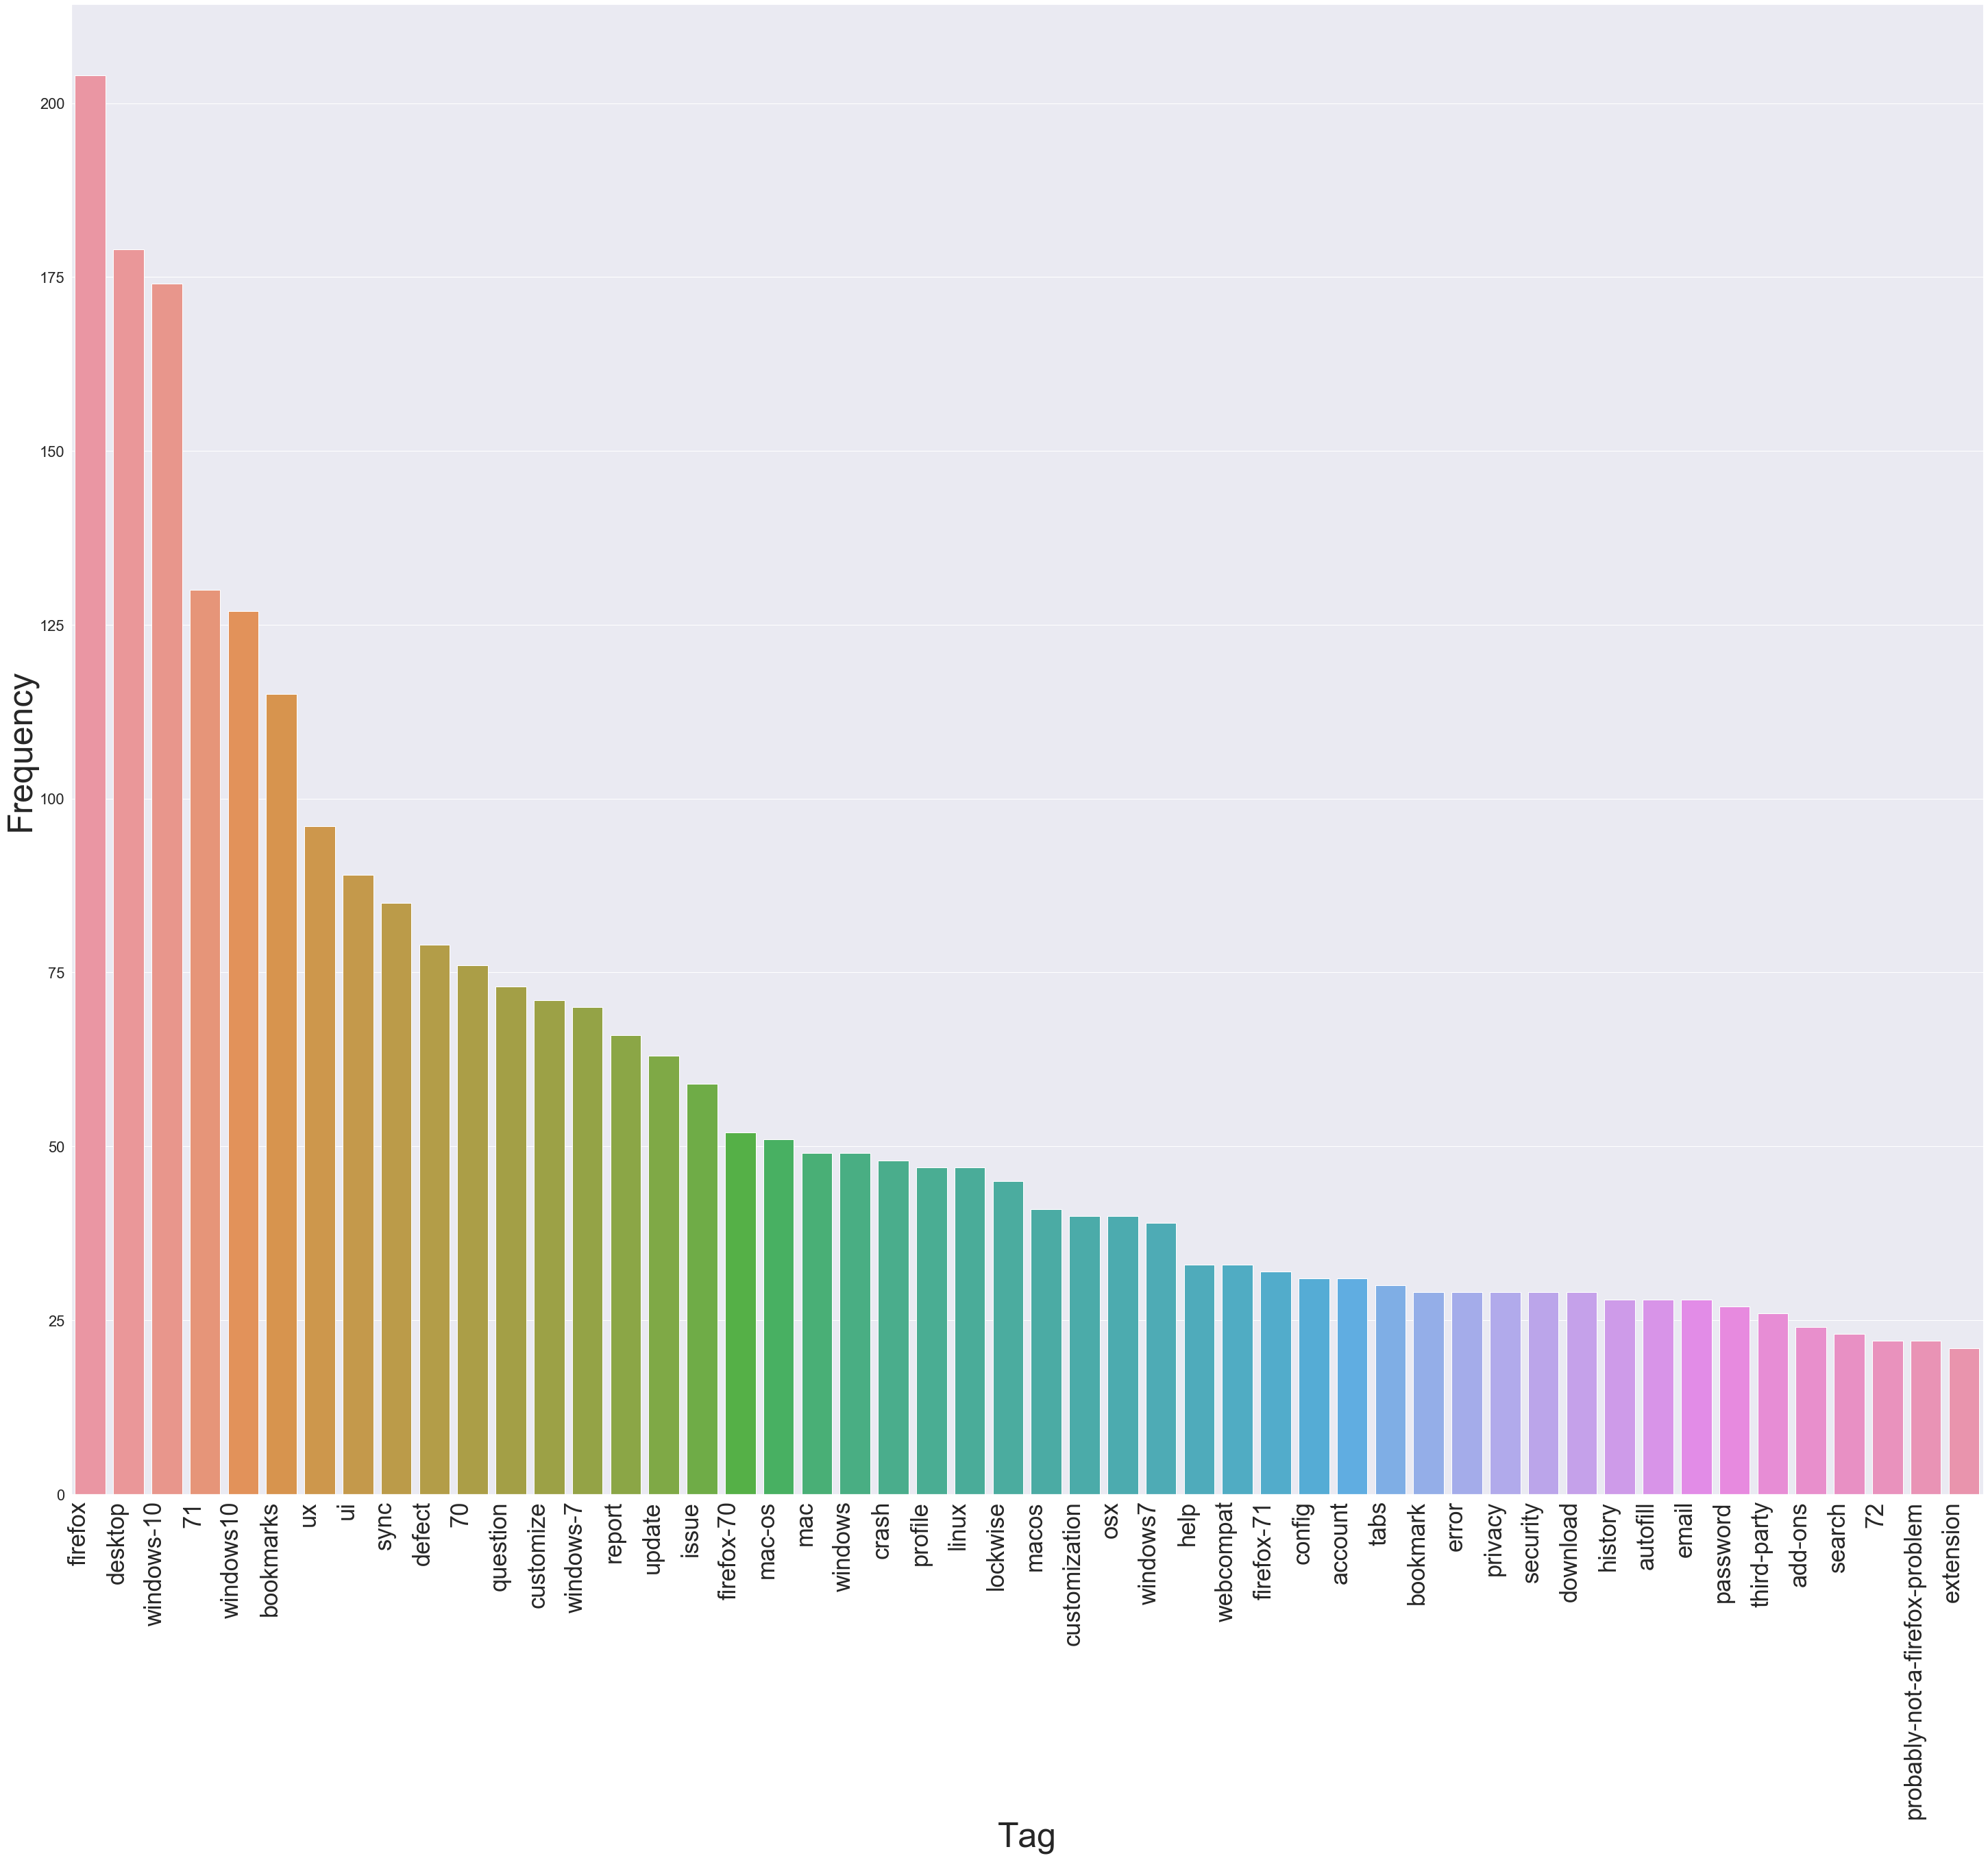

In [10]:
x = [item[0] for item in human_tags_fre.most_common(50)]
y = [item[1] for item in human_tags_fre.most_common(50)] 
sns.set(font_scale = 2)
plt.figure(figsize=(50,40))
ax = sns.barplot(x,y)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right',fontsize='x-large')
plt.xlabel('Tag', fontsize=50)
plt.ylabel('Frequency', fontsize=50)

### build data frame for training

In [11]:
# import all necessary dependencies for training
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

In [12]:
# initialize variables for each model
tag_accuracy = {'MultinomialNB' : [],'ComplementNB':[],'BernoulliNB':[]}
predict_frames = {'MultinomialNB' : {},'ComplementNB':{},'BernoulliNB':{}}
test_data = None
classifiers = {'MultinomialNB':MultinomialNB(), 'ComplementNB':ComplementNB(), 'BernoulliNB':BernoulliNB()}
for tag in candidate_tags:
    ## build data frame
    tids = human_tags_data['ticket_id']
    ticket_content = [all_ticket_dict[tid] for tid in tids]
    data = pd.DataFrame(data = tids, columns=['Ticket ID'])
    data['title_content'] = ticket_content
    data[tag] = [1 if tag in row['tags'] else 0 for index, row in human_tags_data.iterrows()]
    
    # split the data to train and test
    train, test = train_test_split(data, random_state=30, test_size=0.50, shuffle=True)
    train_text = train['title_content']
    test_text = test['title_content']
    
    # convert the text to vector for training use
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
    vectorizer.fit(train_text)
    vectorizer.fit(test_text)
    x_train = vectorizer.transform(train_text)
    y_train = train.drop(labels = ['Ticket ID','title_content'], axis=1)

    x_test = vectorizer.transform(test_text)
    y_test = test.drop(labels = ['Ticket ID','title_content'], axis=1)
    
    # build testing dataframe
    if isinstance(test_data,type(None)):
        test_data = y_test
    else:
        test_data[tag] = y_test

    for model in classifiers:
        
        # training
        classifier = classifiers[model].fit(x_train, y_train[tag])
        
        # predicting
        test_accuracy = classifier.score(x_test, y_test[tag])
        tag_accuracy[model].append(test_accuracy)
        y_predict = classifier.predict(x_test)
        
        # build predicting dataframe
        predict_frames[model][tag] = pd.Series(y_predict)

### Tag accuracy statistics

In [13]:
for model in classifiers:
    print(f"The averge tag accuracy for {model} is {sum(tag_accuracy[model])/50}")

The averge tag accuracy for MultinomialNB is 0.9524343675417658
The averge tag accuracy for ComplementNB is 0.9198568019093077
The averge tag accuracy for BernoulliNB is 0.9392124105011936


### Jaccard score statistics
#### Intersection between human tags and machine suggested tags

In [14]:
for model in classifiers:
    jaccard_total = 0
    predict_data = pd.DataFrame(predict_frames[model])
    for i in range(test_data.index.size):
        score = jaccard_score(test_data.iloc[i],predict_data.iloc[i])
        jaccard_total += score
    print(f"The jaccard overall score for {model} is {jaccard_total}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The jaccard overall score for MultinomialNB is 32.08095238095236
The jaccard overall score for ComplementNB is 122.25074980924784
The jaccard overall score for BernoulliNB is 42.5524572049572


### F beta score
#### we use β = 2 here, because we think the recall rate is more important than the precision rate in our project

In [15]:
for model in classifiers:
    predict_data = pd.DataFrame(predict_frames[model])
    print(f"Fβ2 score on {model} {metrics.fbeta_score(test_data,predict_data,average='weighted',beta=2)}")

Fβ2 score on MultinomialNB 0.055058316283505486
Fβ2 score on ComplementNB 0.23457322589330906
Fβ2 score on BernoulliNB 0.10998273404670622


## Based on accuracy score, jaccard score and the fβ2 score on all three naive bayes models we think ComplementNB is better to use in our project because of it's highest jaccard score and fβ2 score. At the same time, ComplementNB has better ability to handle unbalanced data from the dataset